In [1]:
import plotly.express as px
import pandas as pd
import json
import os
os.environ['USER'] = "rmoine"
from pathlib import Path
import plotly.graph_objects as go
import numpy as np
from typing import *
from llama.main import compute_metrics_from_files, DatasetName, compute_metrics_from_list, get_tokenizer
import llama.main as m
from sklearn.metrics import f1_score, auc, roc_curve, confusion_matrix
from PIL import Image
from pandasql import sqldf
from io import BytesIO
import base64
from plotly.graph_objects import Figure
import win32clipboard
import textwrap
import colorsys
import optuna
import tqdm
import re
import random
from sklearn.metrics import accuracy_score, roc_curve, auc
def img_to_clipboard(fig: Figure):
    img_bytes = fig.to_image(format="png")
    image = Image.open(BytesIO(img_bytes))
    
    output = BytesIO()
    image.convert('RGB').save(output, 'BMP')
    data = output.getvalue()[14:]
    output.close()
    win32clipboard.OpenClipboard()
    win32clipboard.EmptyClipboard()
    win32clipboard.SetClipboardData(win32clipboard.CF_DIB, data)
    win32clipboard.CloseClipboard()
root = Path(f"../../data/baseline_studies/analysis/sel/")

c:\Users\dessa\anaconda3\envs\Master\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin c:\Users\dessa\anaconda3\envs\Master\lib\site-packages\bitsandbytes\libbitsandbytes_cpu.so


c:\Users\dessa\anaconda3\envs\Master\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
CUDA SETUP: Loading binary c:\Users\dessa\anaconda3\envs\Master\lib\site-packages\bitsandbytes\libbitsandbytes_cpu.so...
argument of type 'WindowsPath' is not iterable
Import of import evaluate failed
Import of from pytorchtools import EarlyStopping failed


In [ ]:
l = []
files = list(enumerate(root.rglob("*_0.json")))
for i,f in tqdm.tqdm(files):
    algorithm_group: Literal['bayesian_network','svc','knn']
    if "_nb_" in f.stem:
        algorithm_group = 'bayesian_network'
    elif "_svm_knn_" in f.stem:
        if "KNeighborsClassifier" in f.stem:
            algorithm_group = "knn"
        elif "SVC_" in f.stem:
            algorithm_group = "svc"
        else:
            raise Exception
    else:
        raise Exception
    num_samples = int(re.search("([0-9]+)_samples", f.stem).group(1))
            
    with open(f) as fp:
        data = json.load(fp)[0]
    dataset_choice = "eclipse_72k" if "eclipse_72k" in f.stem else "mozilla_200k"
    fixed_params = {k:v for k,v in data.items() if not isinstance(v, list)}
    fixed_params["params"] = fixed_params
    fixed_params["run_id"] = i
    fixed_params["num_samples"] = num_samples
    fixed_params["algorithm_group"] = algorithm_group
    fixed_params["dataset_choice"] = dataset_choice
    infos = {**fixed_params}
    for dataset in ["val","test"]:
        d = [
            {"binary_severity":b, "severity_pred": p, "bug_id": i} 
            for i,(b,p) in enumerate(zip(
                data[f'binary_severity_{dataset}'],
                data[f'y_{dataset}_pred']
                ))]
        threasholds = sorted(np.unique(filter(lambda x:x is not None,data[f'thresholds_{dataset}'])))
        fpr, tpr, thresholds = roc_curve(data[f'binary_severity_{dataset}'], data[f'y_{dataset}_pred'])
        auc_test = auc(fpr, tpr)
        fig = go.Figure()
        y_scores = data[f'y_{dataset}_pred']
        y_true = data[f'binary_severity_{dataset}']
        roc_data = []
        best_accuracy = 0
        best_threshold = -1
        best_data = None

        for i, threshold in enumerate(thresholds):
            y_pred = (y_scores >= threshold).astype(int)
            cm = confusion_matrix(y_true, y_pred)
            accuracy = np.sum(np.diag(cm))/np.sum(cm)*100
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
                best_data = y_true, y_pred
        assert best_data is not None
        d = [
            {"binary_severity":y_true, "severity_pred": y_pred, "bug_id": i} for i,(y_true, y_pred) in enumerate(zip(*best_data))]
        cm, f1, _ = compute_metrics_from_list(d, pred_field="severity_pred")
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)
        print(f"{dataset=} {f.stem=} {auc_test=}")
        infos[f"accuracy_{dataset}"] = accuracy
        infos[f"auc_{dataset}"] = accuracy
        infos[f"f1_{dataset}"] = f1
        infos[f"threashold_{dataset}"] = best_threshold
        infos[f"confusion_matrix_{dataset}"] = cm
    l.append(infos)
df = pd.DataFrame(l)

In [3]:
def remove_params(d):
    return {k:v for k,v in d.items() if k != "params"}
df.loc[:,"params"] = df["params"].apply(remove_params)
df.to_json("../../data/baseline_studies/baseline_results_analysed_v2.json")

In [2]:
df = pd.read_json("../../data/baseline_studies/baseline_results_analysed_v2.json")

In [3]:
dataset_choice = "eclipse_72k"
d = df.query(f"dataset_choice == '{dataset_choice}'")
d.sort_values(["num_samples","algorithm_group"],inplace=True)
d = d.rename({"accuracy_val": "Validation accuracy with best threshold", "accuracy_test": "Test accuracy with best threshold"}, axis=1)
fig = px.line(
    d,
    x="num_samples",
    y="auc_val",
    color="algorithm_group",
    title=f"Area under the curve for {dataset_choice}",
    markers=True,
)
for i,trace in enumerate(fig.data):
    trace.name =  trace.name + ' validation'
fig2 = px.line(d, x="num_samples", y="auc_test", color="algorithm_group")
for i,trace in enumerate(fig2.data):
    trace.name = trace.name + ' test'
fig2.update_traces(patch={"line": {"dash": 'dot', 'width': 4}}) 
for i in range(3):
    fig.add_trace(fig2.data[i])
fig.update_layout(
    font=dict(size=16)  # Set the default font size for all text elements in the figure
)
fig.update_yaxes(title_text="Area under the curve")
fig.show()

C:\Users\dessa\AppData\Local\Temp\ipykernel_5176\3182048694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.sort_values(["num_samples","algorithm_group"],inplace=True)


C:\Users\dessa\AppData\Local\Temp\ipykernel_5176\2610381185.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



eclipse_72k Validation threashold 0.00 BernoulliNB {'seed': 0, 'classifier': 'BernoulliNB', 'train_fun': 'train', 'train_accuracy': 0.53325, 'fold_id': 0, 'auc_val': 0.7567386292, 'classifier_name': 'BernoulliNB', 'alpha': 0.27541016560000003, 'fit_prior': False, 'binarize': 0.3164602065, 'auc_test': 0.7567386292, 'run_id': 3, 'num_samples': 4000, 'algorithm_group': 'bayesian_network', 'dataset_choice': 'eclipse_72k'}


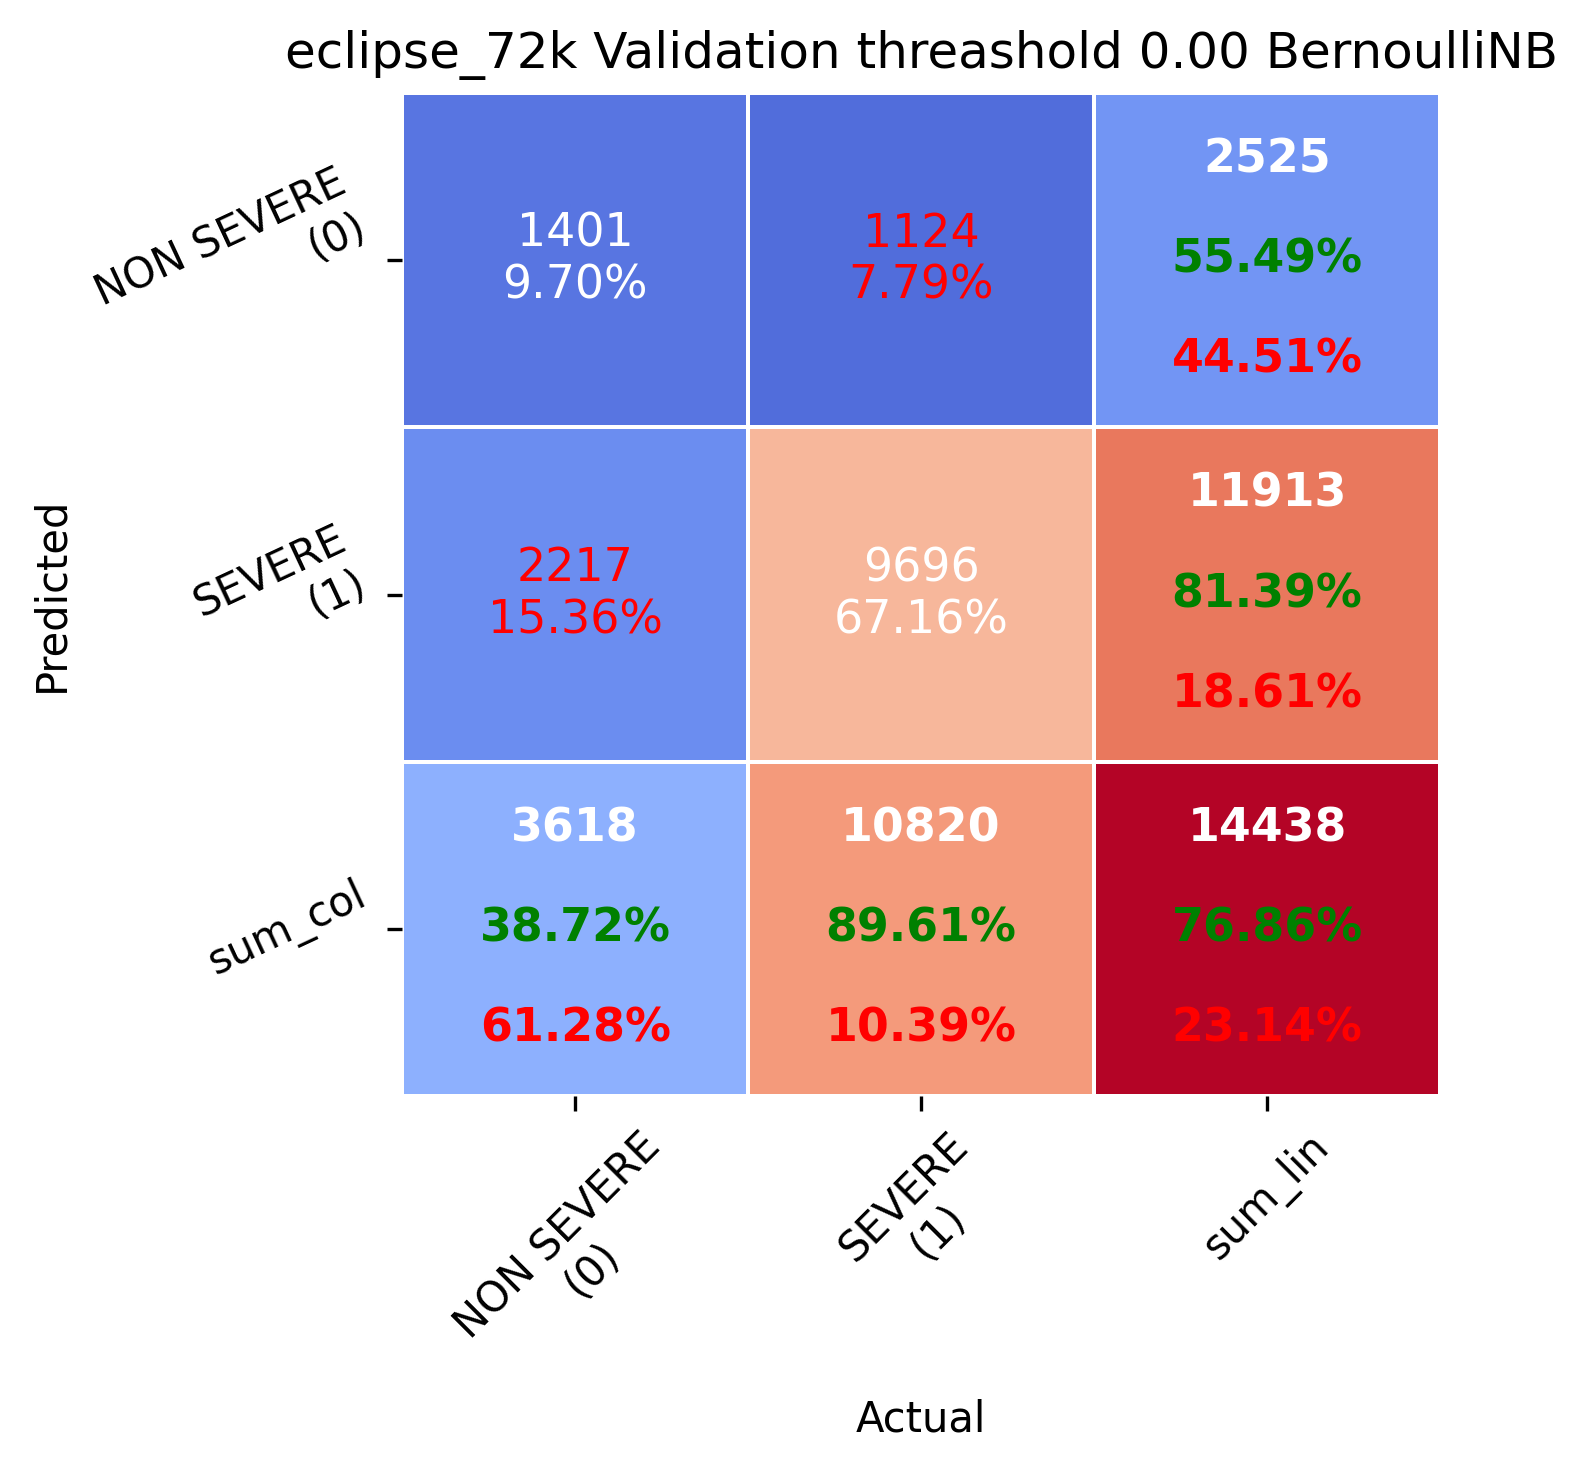

eclipse_72k Test threashold 0.00 BernoulliNB {'seed': 0, 'classifier': 'BernoulliNB', 'train_fun': 'train', 'train_accuracy': 0.53325, 'fold_id': 0, 'auc_val': 0.7567386292, 'classifier_name': 'BernoulliNB', 'alpha': 0.27541016560000003, 'fit_prior': False, 'binarize': 0.3164602065, 'auc_test': 0.7567386292, 'run_id': 3, 'num_samples': 4000, 'algorithm_group': 'bayesian_network', 'dataset_choice': 'eclipse_72k'}


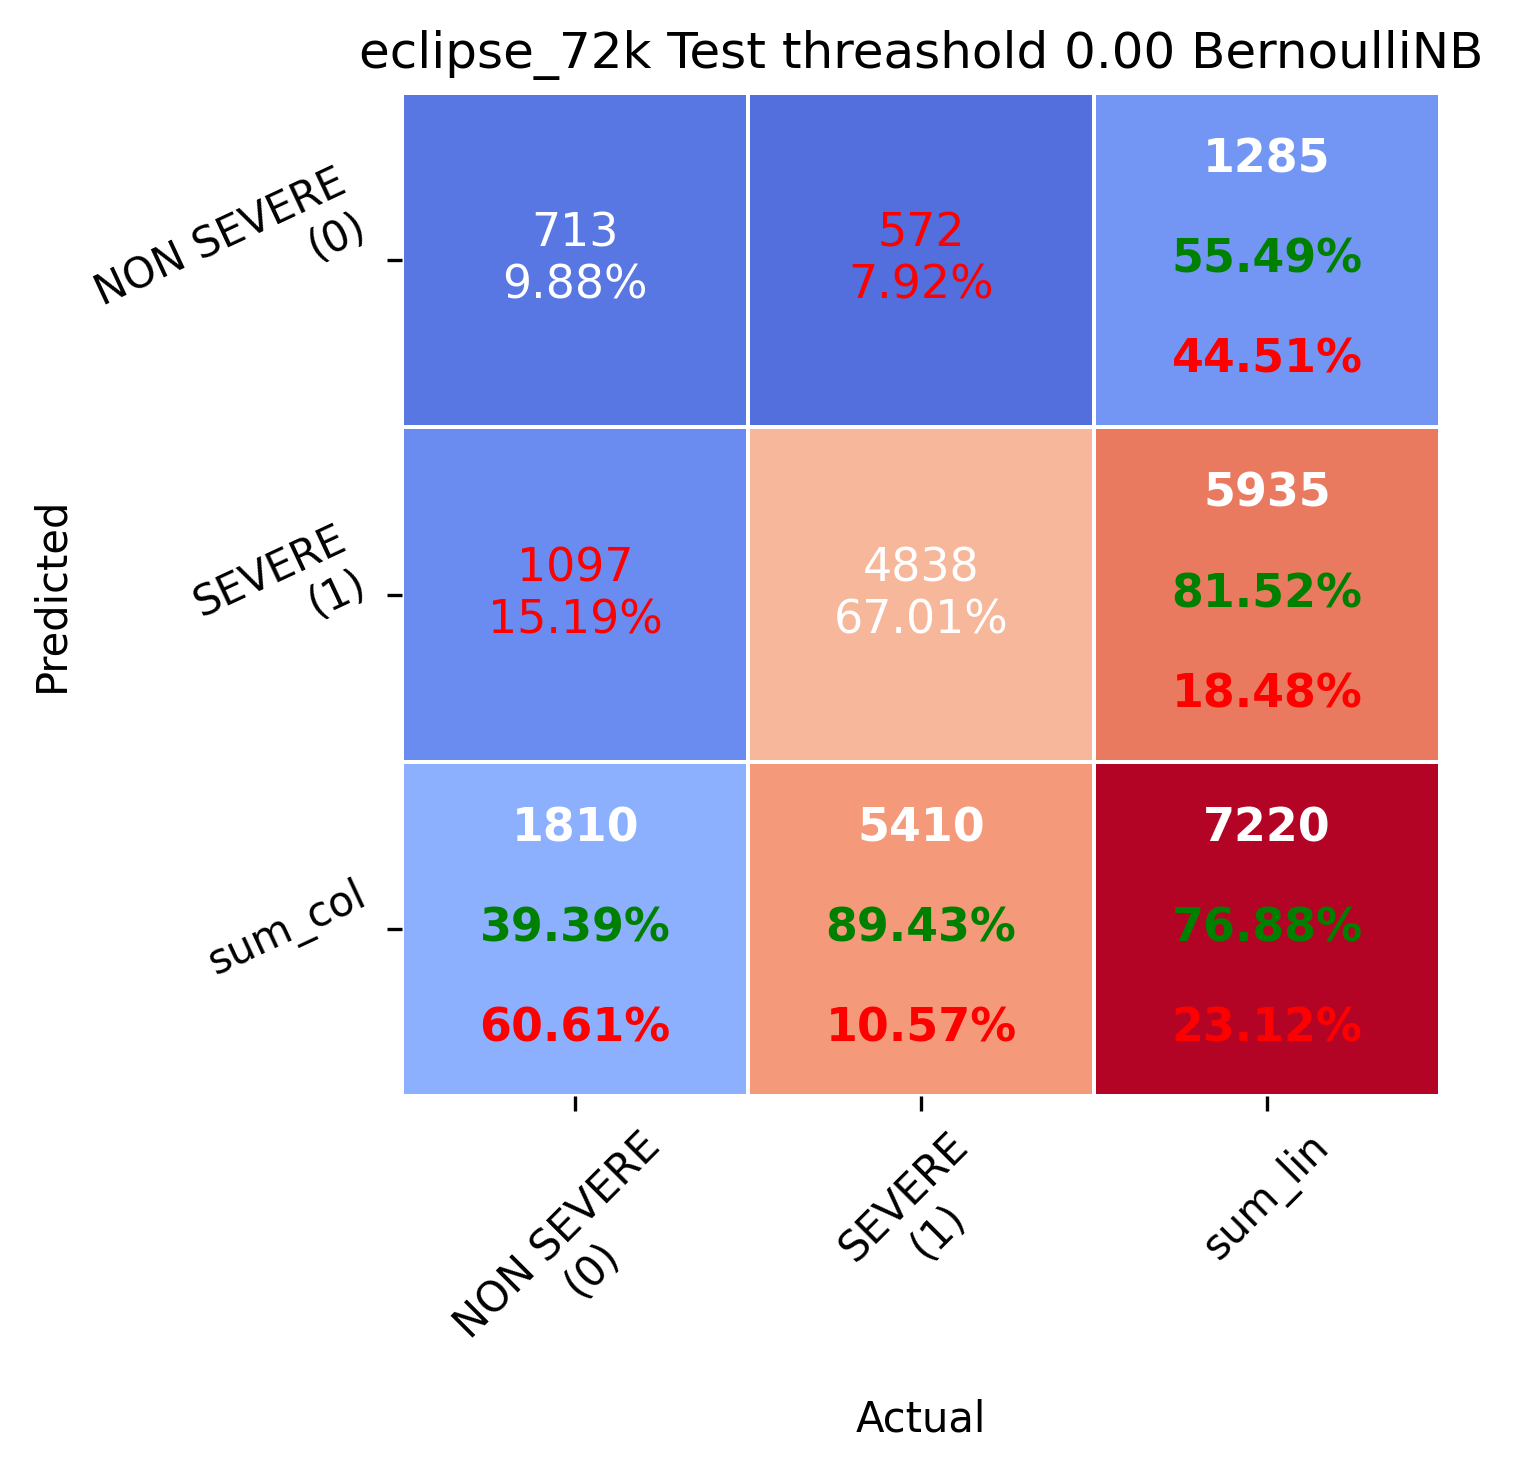

eclipse_72k Validation threashold 0.14 KNeighborsClassifier {'seed': 0, 'classifier': 'KNeighborsClassifier', 'train_fun': 'train', 'train_accuracy': 0.99975, 'fold_id': 0, 'auc_val': 0.5959496265, 'classifier_name': 'KNeighborsClassifier', 'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 30, 'p': 3, 'auc_test': 0.5959496265, 'run_id': 15, 'num_samples': 4000, 'algorithm_group': 'knn', 'dataset_choice': 'eclipse_72k'}


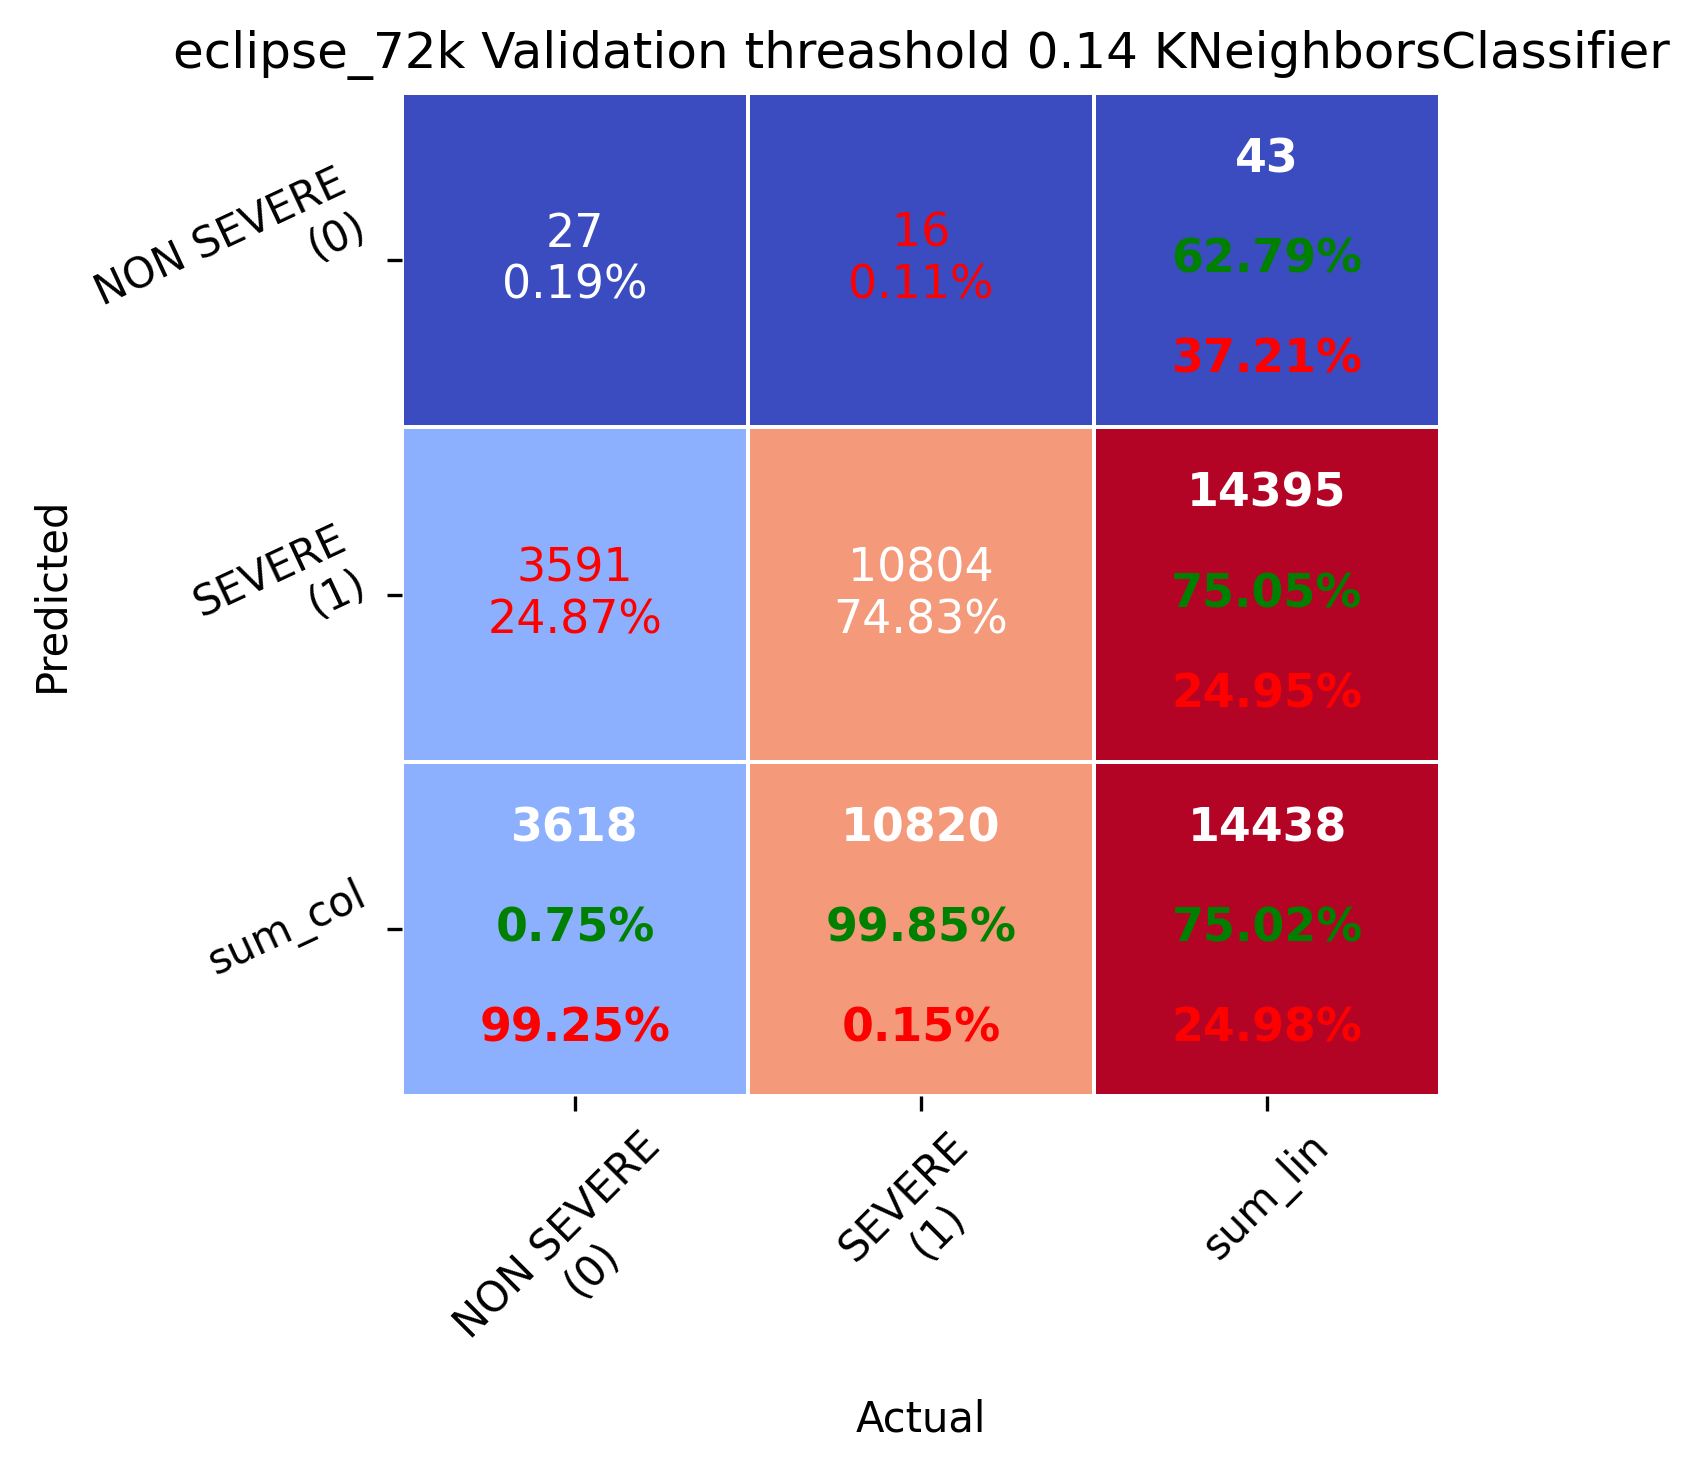

eclipse_72k Test threashold 0.13 KNeighborsClassifier {'seed': 0, 'classifier': 'KNeighborsClassifier', 'train_fun': 'train', 'train_accuracy': 0.99975, 'fold_id': 0, 'auc_val': 0.5959496265, 'classifier_name': 'KNeighborsClassifier', 'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 30, 'p': 3, 'auc_test': 0.5959496265, 'run_id': 15, 'num_samples': 4000, 'algorithm_group': 'knn', 'dataset_choice': 'eclipse_72k'}


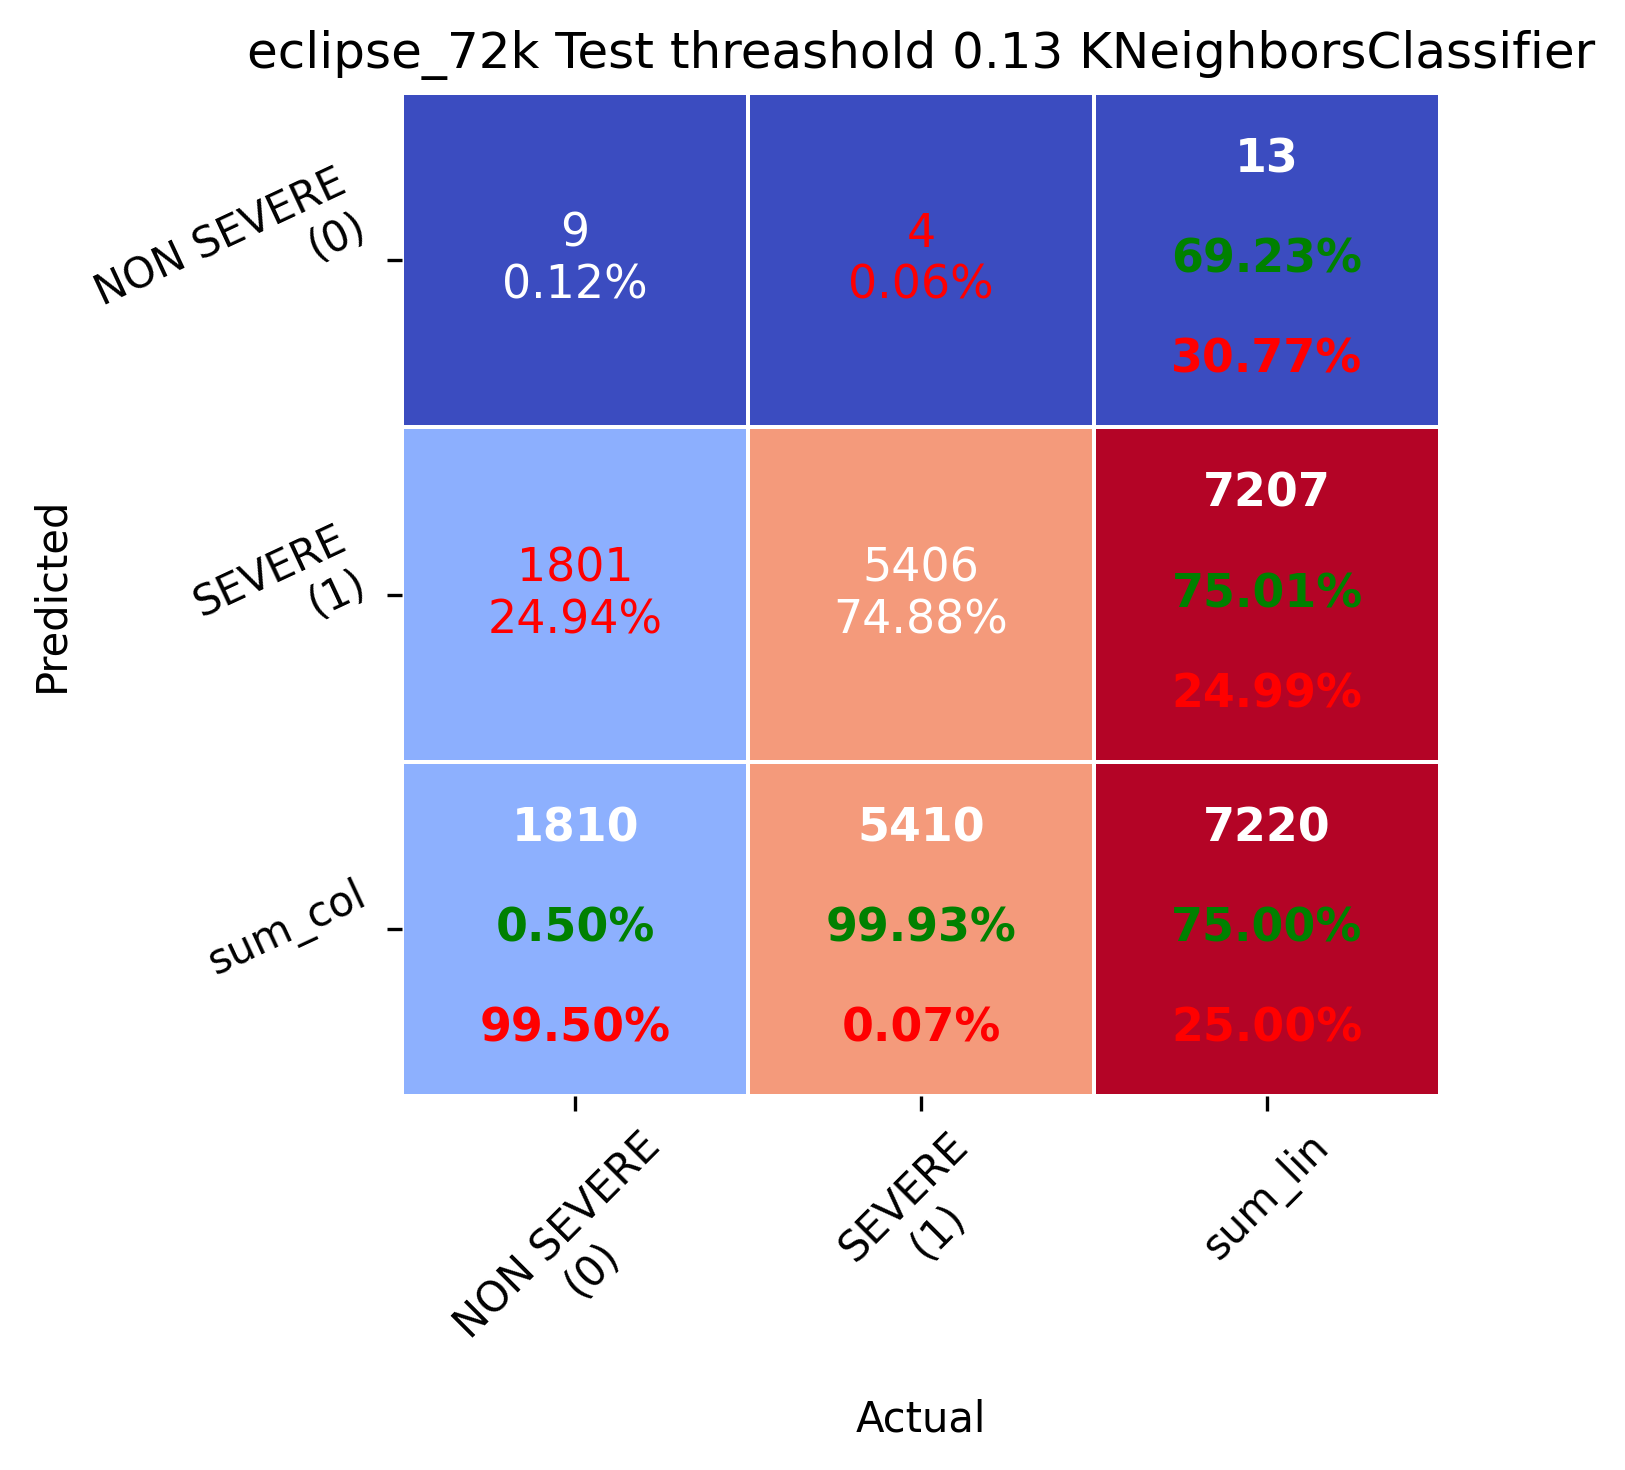

eclipse_72k Validation threashold 0.52 SVC {'seed': 0, 'classifier': 'SVC', 'train_fun': 'train', 'train_accuracy': 0.9585, 'fold_id': 0, 'auc_val': 0.7523357616, 'classifier_name': 'SVC', 'C': 2.6848703431, 'kernel': 'poly', 'degree': 1, 'gamma': 'scale', 'coef0': -0.6583804001, 'shrinking': False, 'probability': True, 'tol': 0.0157409154, 'class_weight': 'balanced', 'max_iter': -1, 'decision_function_shape': 'ovo', 'break_ties': False, 'auc_test': 0.7523357616, 'run_id': 27, 'num_samples': 4000, 'algorithm_group': 'svc', 'dataset_choice': 'eclipse_72k'}


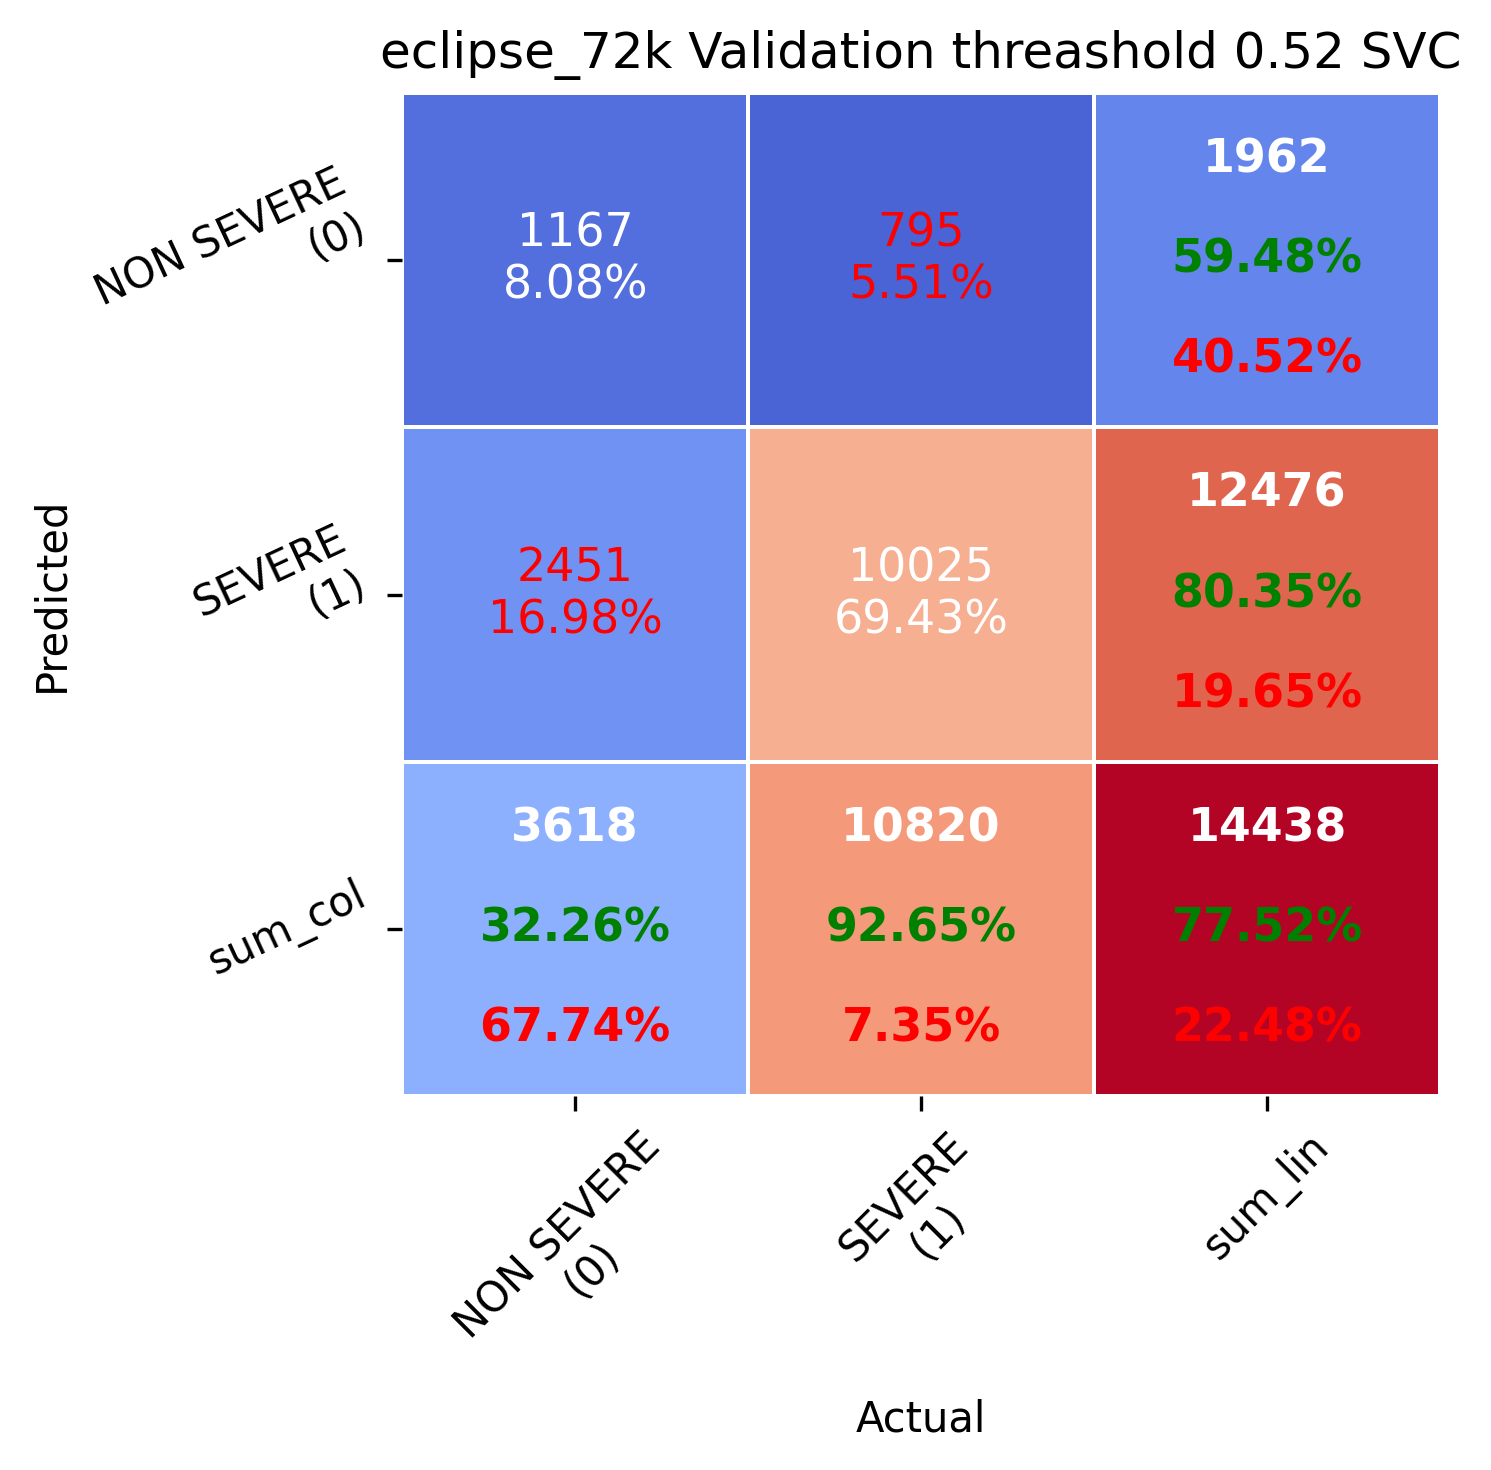

eclipse_72k Test threashold 0.52 SVC {'seed': 0, 'classifier': 'SVC', 'train_fun': 'train', 'train_accuracy': 0.9585, 'fold_id': 0, 'auc_val': 0.7523357616, 'classifier_name': 'SVC', 'C': 2.6848703431, 'kernel': 'poly', 'degree': 1, 'gamma': 'scale', 'coef0': -0.6583804001, 'shrinking': False, 'probability': True, 'tol': 0.0157409154, 'class_weight': 'balanced', 'max_iter': -1, 'decision_function_shape': 'ovo', 'break_ties': False, 'auc_test': 0.7523357616, 'run_id': 27, 'num_samples': 4000, 'algorithm_group': 'svc', 'dataset_choice': 'eclipse_72k'}


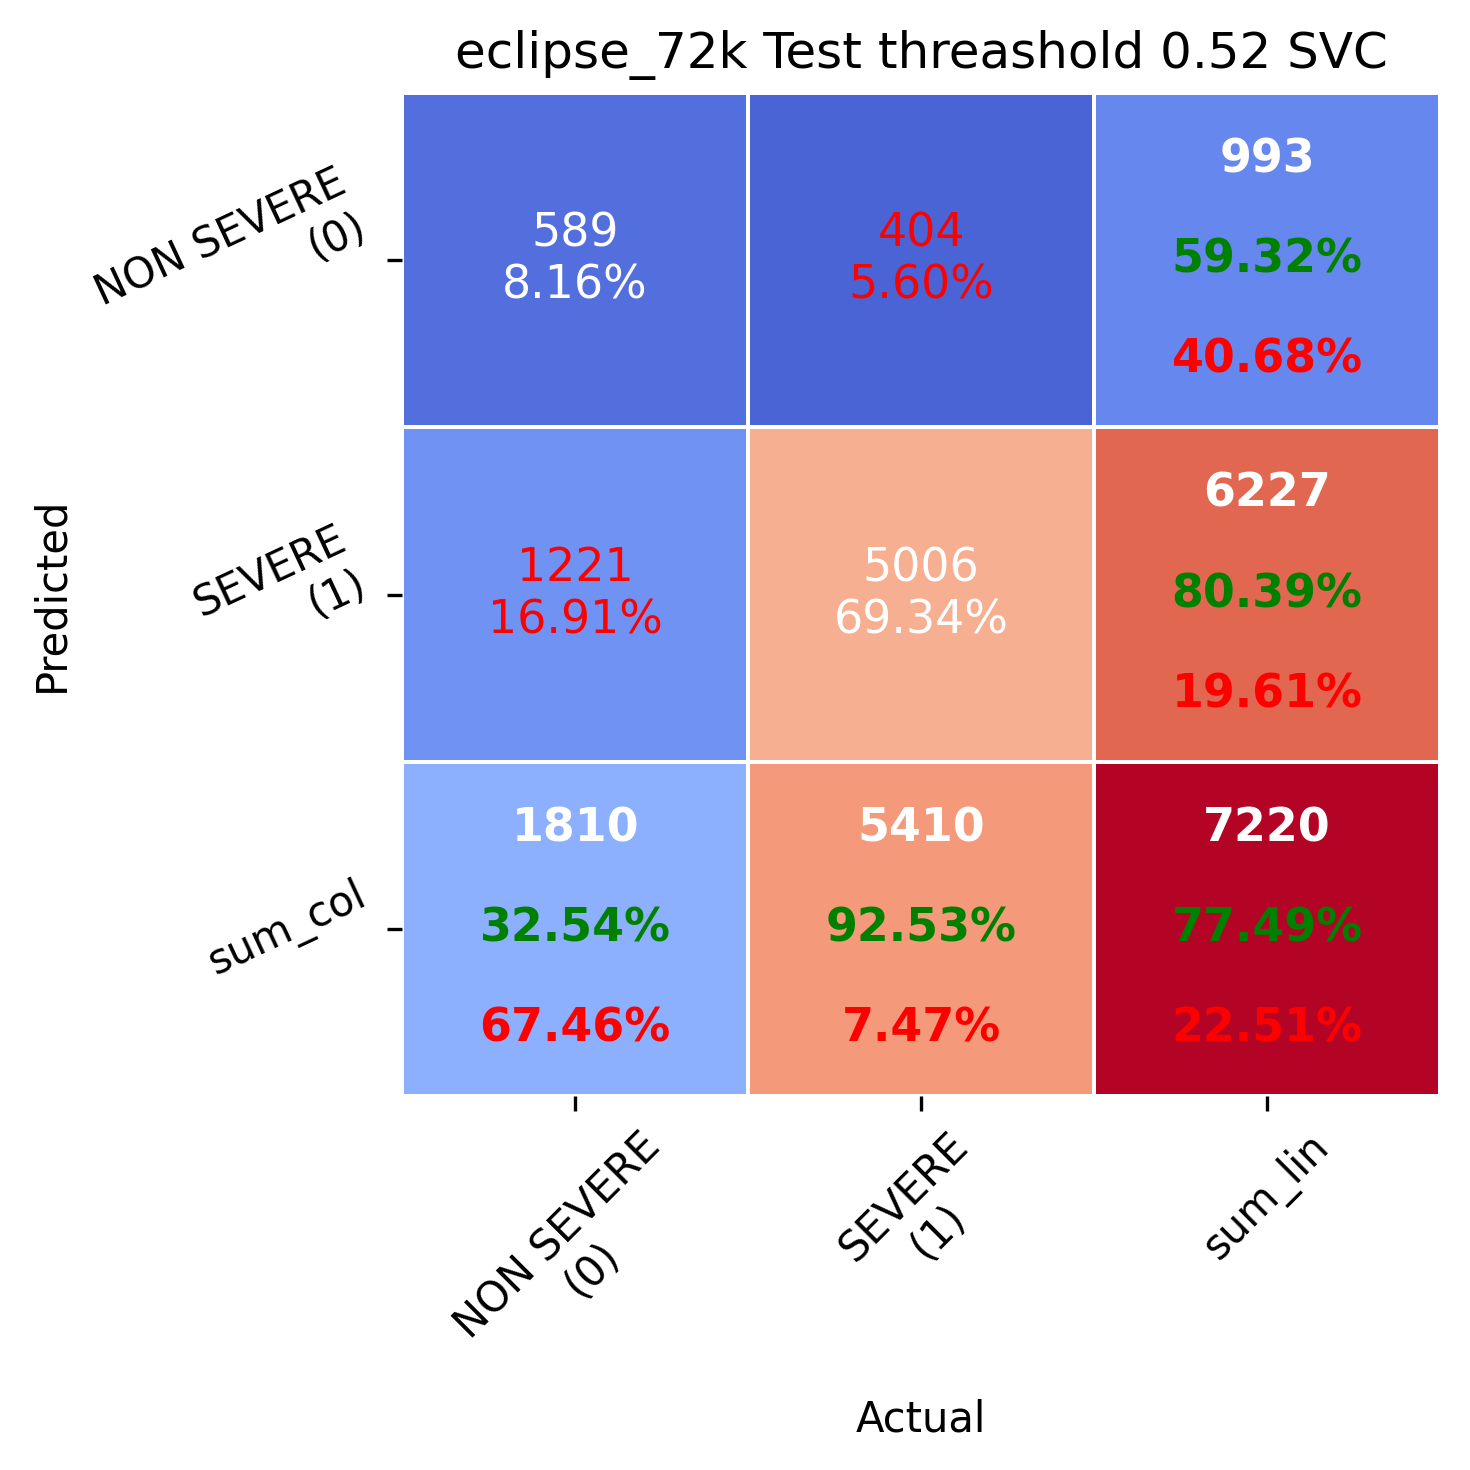

In [4]:
dataset_choice = "eclipse_72k"
d = df.query(f"dataset_choice == '{dataset_choice}' & num_samples == 4000")
d.sort_values(["num_samples","algorithm_group"],inplace=True)
for i,l in d.iterrows():
    conf_matrix_test = l["confusion_matrix_test"]
    algo = l['classifier']
    for conf_matrix_name, conf_matrix_id in zip(["Validation", "Test"],["val","test"]):
        conf_matrix = l[f"confusion_matrix_{conf_matrix_id}"]
        f1 = l[f"f1_{conf_matrix_id}"]
        threashold = l[f"threashold_{conf_matrix_id}"]
        print(f"{dataset_choice} {conf_matrix_name} threashold {threashold:.2f} {algo}", l.params)
        compute_metrics_from_files(
            conf_matrix=np.array(conf_matrix),
            f1=f1,
            folder_out=Path("../../data/baseline_studies/"),
            title=f"{dataset_choice} {conf_matrix_name} threashold {threashold:.2f} {algo}",
            id=f"{dataset_choice}_{conf_matrix_name}_{algo}",
            backend=None,
            dpi=300,
        )

In [5]:
dataset_choice = "mozilla_200k"
d = df.query(f"dataset_choice == '{dataset_choice}'")
d.sort_values(["num_samples","algorithm_group"],inplace=True)
d = d.rename({"accuracy_val": "Validation accuracy with best threshold", "accuracy_test": "Test accuracy with best threshold"}, axis=1)
fig = px.line(
    d,
    x="num_samples",
    y="auc_val",
    color="algorithm_group",
    title=f"Area under the curve for {dataset_choice}",
    markers=True,
)
for i,trace in enumerate(fig.data):
    trace.name =  trace.name + ' validation'
fig2 = px.line(d, x="num_samples", y="auc_test", color="algorithm_group")
for i,trace in enumerate(fig2.data):
    trace.name = trace.name + ' test'
fig2.update_traces(patch={"line": {"dash": 'dot', 'width': 4}}) 
for i in range(3):
    fig.add_trace(fig2.data[i])
fig.update_layout(
    font=dict(size=16)  # Set the default font size for all text elements in the figure
)
fig.update_yaxes(title_text="Area under the curve")
fig.show()

C:\Users\robin\AppData\Local\Temp\ipykernel_16784\3485171786.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
dataset_choice = "mozilla_200k"
d = df.query(f"dataset_choice == '{dataset_choice}' & num_samples == 8000")
d.sort_values(["num_samples","algorithm_group"],inplace=True)
for i,l in d.iterrows():
    conf_matrix_test = l["confusion_matrix_test"]
    algo = l['classifier']
    for conf_matrix_name, conf_matrix_id in zip(["Validation", "Test"],["val","test"]):
        conf_matrix = l[f"confusion_matrix_{conf_matrix_id}"]
        f1 = l[f"f1_{conf_matrix_id}"]
        threashold = l[f"threashold_{conf_matrix_id}"]
        compute_metrics_from_files(
            conf_matrix=conf_matrix,
            f1=f1,
            folder_out=Path("../../data/baseline_studies/"),
            title=f"{dataset_choice} {conf_matrix_name} threashold {threashold:.2f}",
            id=f"{dataset_choice}_{conf_matrix_name}"
        )

C:\Users\robin\AppData\Local\Temp\ipykernel_16784\3960788679.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\robin\Documents\projets\severityPrediction\src\llm\llama\main.py:907: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\robin\Documents\projets\severityPrediction\src\llm\llama\main.py:907: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\robin\Documents\projets\severityPrediction\src\llm\llama\main.py:907: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\robin\Documents\projets\severityPrediction\src\llm\llama\main.py:907: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

c:\Users\robin\Documents\projets\severityPrediction\src\llm\llama\main.py:907: U